**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/deep` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

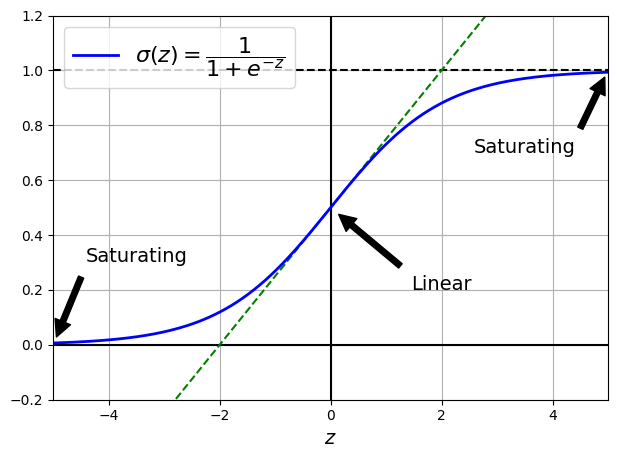

In [5]:
# extra code – this cell generates and saves Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [7]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

### Leaky ReLU

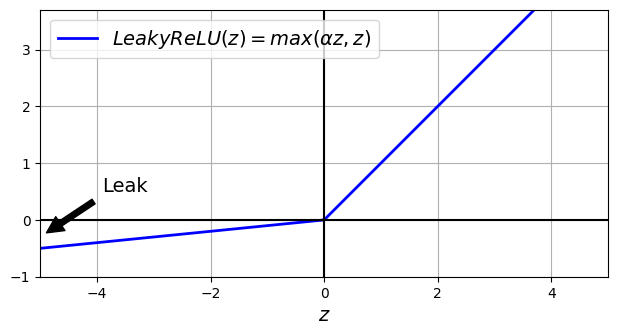

In [8]:
# extra code – this cell generates and saves Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [9]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [10]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [11]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

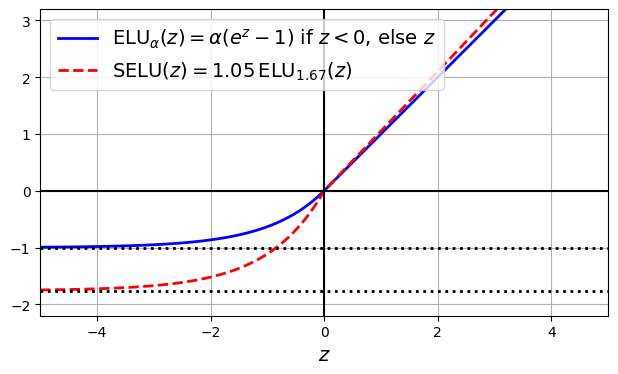

In [12]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [13]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [14]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [16]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [18]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 26s 11ms/step - loss: 1.0212 - accuracy: 0.6211 - val_loss: 0.6895 - val_accuracy: 0.7536
Epoch 2/5
1719/1719 [==============================] - 20s 12ms/step - loss: 0.6498 - accuracy: 0.7651 - val_loss: 0.5725 - val_accuracy: 0.8022
Epoch 3/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.5589 - accuracy: 0.8043 - val_loss: 0.5187 - val_accuracy: 0.8130
Epoch 4/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5242 - accuracy: 0.8212 - val_loss: 0.5230 - val_accuracy: 0.8176
Epoch 5/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.4735 - accuracy: 0.8385 - val_loss: 0.4632 - val_accuracy: 0.8408


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [20]:
tf.random.set_seed(42)

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


1719/1719 [==============================] - 20s 9ms/step - loss: 1.8653 - accuracy: 0.2345 - val_loss: 1.5168 - val_accuracy: 0.3444
Epoch 2/5
1719/1719 [==============================] - 14s 8ms/step - loss: 1.3345 - accuracy: 0.3996 - val_loss: 1.1894 - val_accuracy: 0.4584
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.0988 - accuracy: 0.5356 - val_loss: 0.9901 - val_accuracy: 0.5744
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.9401 - accuracy: 0.6225 - val_loss: 0.8986 - val_accuracy: 0.6376
Epoch 5/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.8600 - accuracy: 0.6694 - val_loss: 0.8496 - val_accuracy: 0.6616


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

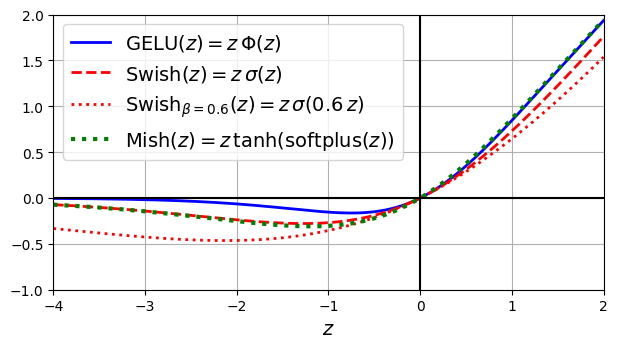

In [24]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

# Batch Normalization

In [25]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [28]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [29]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2


1719/1719 [==============================] - 5s 3ms/step - loss: 0.5613 - accuracy: 0.8062 - val_loss: 0.4050 - val_accuracy: 0.8482
Epoch 2/2
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4088 - accuracy: 0.8552 - val_loss: 0.3620 - val_accuracy: 0.8672


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [30]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [32]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2


1719/1719 [==============================] - 5s 2ms/step - loss: 0.6068 - accuracy: 0.7967 - val_loss: 0.4367 - val_accuracy: 0.8436
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4272 - accuracy: 0.8507 - val_loss: 0.3775 - val_accuracy: 0.8666


## Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [33]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [34]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [35]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 2s 1ms/step - loss: 1.1218 - accuracy: 0.6472 - val_loss: 0.6964 - val_accuracy: 0.7651
Epoch 2/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.6073 - accuracy: 0.7998 - val_loss: 0.5202 - val_accuracy: 0.8253
Epoch 3/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.4913 - accuracy: 0.8409 - val_loss: 0.4452 - val_accuracy: 0.8483
Epoch 4/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.4300 - accuracy: 0.8613 - val_loss: 0.3984 - val_accuracy: 0.8659
Epoch 5/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3913 - accuracy: 0.8725 - val_loss: 0.3704 - val_accuracy: 0.8701
Epoch 6/20
1376/1376 [==============================] - 2s 2ms/step - loss: 0.3644 - accuracy: 0.8793 - val_loss: 0.3493 - val_accuracy: 0.8764
Epoch 7/20
1376/1376 [==============================] - 2s 2ms/step - loss: 0.3452 - accuracy: 0.8841 - val_loss: 0.3340 - val_accuracy:

INFO:tensorflow:Assets written to: my_model_A\assets


In [36]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 31ms/step - loss: 0.6360 - accuracy: 0.5750 - val_loss: 0.6378 - val_accuracy: 0.5529
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 0.6150 - accuracy: 0.5900 - val_loss: 0.6199 - val_accuracy: 0.5836
Epoch 3/20
7/7 [==============================] - 0s 11ms/step - loss: 0.5979 - accuracy: 0.6350 - val_loss: 0.6051 - val_accuracy: 0.6261
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5822 - accuracy: 0.6750 - val_loss: 0.5907 - val_accuracy: 0.6825
Epoch 5/20
7/7 [==============================] - 0s 12ms/step - loss: 0.5677 - accuracy: 0.7250 - val_loss: 0.5759 - val_accuracy: 0.7349
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.5530 - accuracy: 0.7600 - val_loss: 0.5623 - val_accuracy: 0.7834
Epoch 7/20
7/7 [==============================] - 0s 11ms/step - loss: 0.5390 - accuracy: 0.8050 - val_loss: 0.5491 - val_accuracy: 0.8348
Epoch 8/20
7/7 [===========

[0.44570863246917725, 0.9039999842643738]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [37]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [38]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [39]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [40]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [41]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [42]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4


7/7 [==============================] - 1s 109ms/step - loss: 4.7597 - accuracy: 0.5550 - val_loss: 4.4056 - val_accuracy: 0.5153
Epoch 2/4
7/7 [==============================] - 0s 9ms/step - loss: 3.6906 - accuracy: 0.5550 - val_loss: 3.3435 - val_accuracy: 0.5153
Epoch 3/4
7/7 [==============================] - 0s 9ms/step - loss: 2.7126 - accuracy: 0.5550 - val_loss: 2.4001 - val_accuracy: 0.5153
Epoch 4/4
7/7 [==============================] - 0s 8ms/step - loss: 1.8577 - accuracy: 0.5550 - val_loss: 1.5547 - val_accuracy: 0.5153
Epoch 1/16
7/7 [==============================] - 1s 44ms/step - loss: 1.0343 - accuracy: 0.5500 - val_loss: 0.8024 - val_accuracy: 0.3432
Epoch 2/16
7/7 [==============================] - 0s 10ms/step - loss: 0.7266 - accuracy: 0.4700 - val_loss: 0.7243 - val_accuracy: 0.4847
Epoch 3/16
7/7 [==============================] - 0s 9ms/step - loss: 0.6590 - accuracy: 0.5950 - val_loss: 0.6793 - val_accuracy: 0.5678
Epoch 4/16
7/7 [============================

So, what's the final verdict?

In [43]:
model_B_on_A.evaluate(X_test_B, y_test_B)

 1/63 [..............................] - ETA: 1s - loss: 0.3777 - accuracy: 0.9375

63/63 [==============================] - 0s 967us/step - loss: 0.3608 - accuracy: 0.9230


[0.3607889413833618, 0.9229999780654907]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%:

In [44]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

# Faster Optimizers

In [45]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [47]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10


1719/1719 [==============================] - 3s 1ms/step - loss: 0.7073 - accuracy: 0.7586 - val_loss: 0.5127 - val_accuracy: 0.8130
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4668 - accuracy: 0.8341 - val_loss: 0.4422 - val_accuracy: 0.8416
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4239 - accuracy: 0.8497 - val_loss: 0.4223 - val_accuracy: 0.8468
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3962 - accuracy: 0.8603 - val_loss: 0.3831 - val_accuracy: 0.8636
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3747 - accuracy: 0.8660 - val_loss: 0.3699 - val_accuracy: 0.8638
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3605 - accuracy: 0.8712 - val_loss: 0.3648 - val_accuracy: 0.8724
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3438 - accuracy: 0.8763 - val_loss: 0.3615 - val_accuracy: 0.8688
Epo

## Momentum optimization

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [49]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7118 - accuracy: 0.7575 - val_loss: 0.5098 - val_accuracy: 0.8218
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4720 - accuracy: 0.8358 - val_loss: 0.4554 - val_accuracy: 0.8340
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4249 - accuracy: 0.8500 - val_loss: 0.4175 - val_accuracy: 0.8504
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3968 - accuracy: 0.8596 - val_loss: 0.3876 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3757 - accuracy: 0.8665 - val_loss: 0.3723 - val_accuracy: 0.8664
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3627 - accuracy: 0.8686 - val_loss: 0.3695 - val_accuracy: 0.8658
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3461 - accuracy: 0.8755 - val_loss: 0.3675 - val_accuracy:

## Nesterov Accelerated Gradient

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [51]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6821 - accuracy: 0.7672 - val_loss: 0.4867 - val_accuracy: 0.8232
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4598 - accuracy: 0.8382 - val_loss: 0.4363 - val_accuracy: 0.8396
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4190 - accuracy: 0.8526 - val_loss: 0.3985 - val_accuracy: 0.8578
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3931 - accuracy: 0.8615 - val_loss: 0.3837 - val_accuracy: 0.8626
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3728 - accuracy: 0.8680 - val_loss: 0.3717 - val_accuracy: 0.8654
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3596 - accuracy: 0.8718 - val_loss: 0.3856 - val_accuracy: 0.8624
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3447 - accuracy: 0.8753 - val_loss: 0.3767 - val_accuracy:

## AdaGrad

In [52]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [53]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.9753 - accuracy: 0.6851 - val_loss: 0.6776 - val_accuracy: 0.7798
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6266 - accuracy: 0.7942 - val_loss: 0.5718 - val_accuracy: 0.8060
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5566 - accuracy: 0.8149 - val_loss: 0.5275 - val_accuracy: 0.8172
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5214 - accuracy: 0.8262 - val_loss: 0.5043 - val_accuracy: 0.8236
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4988 - accuracy: 0.8332 - val_loss: 0.4867 - val_accuracy: 0.8274
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4830 - accuracy: 0.8368 - val_loss: 0.4767 - val_accuracy: 0.8334
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4707 - accuracy: 0.8403 - val_loss: 0.4642 - val_accuracy:

## RMSProp

In [54]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [55]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5167 - accuracy: 0.8133 - val_loss: 0.4796 - val_accuracy: 0.8214
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3943 - accuracy: 0.8572 - val_loss: 0.4490 - val_accuracy: 0.8312
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3677 - accuracy: 0.8682 - val_loss: 0.3901 - val_accuracy: 0.8636
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3592 - accuracy: 0.8741 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3514 - accuracy: 0.8755 - val_loss: 0.3838 - val_accuracy: 0.8716
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3457 - accuracy: 0.8802 - val_loss: 0.4081 - val_accuracy: 0.8652
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3482 - accuracy: 0.8792 - val_loss: 0.4558 - val_accuracy:

## Adam Optimization

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [57]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4981 - accuracy: 0.8225 - val_loss: 0.4343 - val_accuracy: 0.8310
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3755 - accuracy: 0.8637 - val_loss: 0.4040 - val_accuracy: 0.8448
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3433 - accuracy: 0.8739 - val_loss: 0.3469 - val_accuracy: 0.8734
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3183 - accuracy: 0.8833 - val_loss: 0.3440 - val_accuracy: 0.8770
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3004 - accuracy: 0.8880 - val_loss: 0.3247 - val_accuracy: 0.8760
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2875 - accuracy: 0.8925 - val_loss: 0.3374 - val_accuracy: 0.8814
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2740 - accuracy: 0.8971 - val_loss: 0.3346 - val_accuracy:

**Adamax Optimization**

In [58]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [59]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5406 - accuracy: 0.8125 - val_loss: 0.4548 - val_accuracy: 0.8308
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3979 - accuracy: 0.8586 - val_loss: 0.3827 - val_accuracy: 0.8582
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3594 - accuracy: 0.8701 - val_loss: 0.3629 - val_accuracy: 0.8684
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3334 - accuracy: 0.8794 - val_loss: 0.3458 - val_accuracy: 0.8708
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3134 - accuracy: 0.8853 - val_loss: 0.3326 - val_accuracy: 0.8768
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2995 - accuracy: 0.8917 - val_loss: 0.3340 - val_accuracy: 0.8828
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2864 - accuracy: 0.8947 - val_loss: 0.3367 - val_accuracy:

**Nadam Optimization**

In [60]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [61]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4851 - accuracy: 0.8268 - val_loss: 0.4096 - val_accuracy: 0.8440
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3645 - accuracy: 0.8669 - val_loss: 0.3777 - val_accuracy: 0.8526
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3312 - accuracy: 0.8777 - val_loss: 0.3367 - val_accuracy: 0.8790
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3113 - accuracy: 0.8872 - val_loss: 0.3229 - val_accuracy: 0.8778
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2919 - accuracy: 0.8916 - val_loss: 0.3271 - val_accuracy: 0.8768
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2788 - accuracy: 0.8962 - val_loss: 0.3502 - val_accuracy: 0.8774
Epoch 7/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2670 - accuracy: 0.8990 - val_loss: 0.3511 - val_accuracy:

**AdamW Optimization**

Note: Since TF 1.12, `AdamW` is no longer experimental. It is available at `tf.keras.optimizers.AdamW` instead of `tf.keras.optimizers.experimental.AdamW`.

In [62]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [63]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4965 - accuracy: 0.8217 - val_loss: 0.4128 - val_accuracy: 0.8356
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3746 - accuracy: 0.8624 - val_loss: 0.3935 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3380 - accuracy: 0.8748 - val_loss: 0.3604 - val_accuracy: 0.8700
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3150 - accuracy: 0.8842 - val_loss: 0.3358 - val_accuracy: 0.8794
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2967 - accuracy: 0.8885 - val_loss: 0.3223 - val_accuracy: 0.8808
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2817 - accuracy: 0.8939 - val_loss: 0.3402 - val_accuracy: 0.8794
Epoch 7/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2698 - accuracy: 0.8980 - val_loss: 0.3623 - val_accuracy:

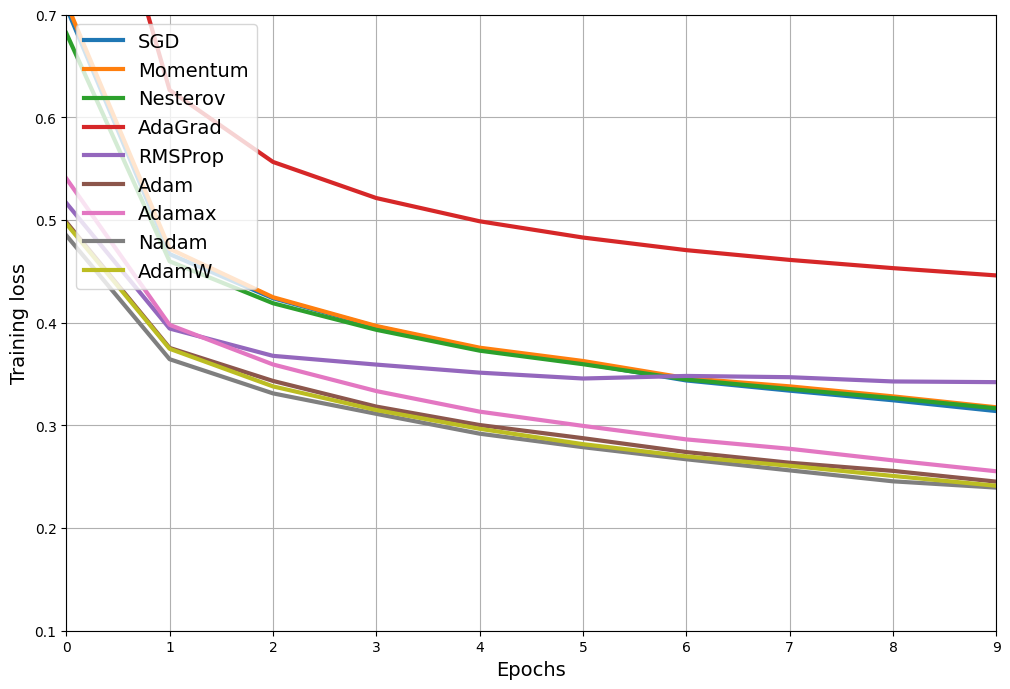

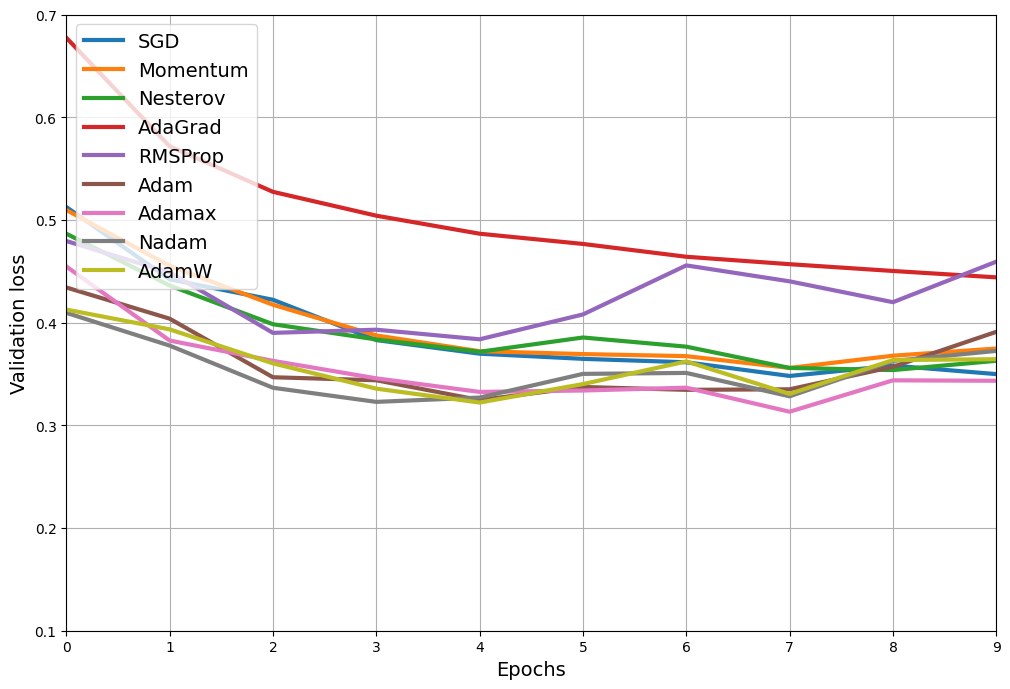

In [64]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```python
learning_rate = initial_learning_rate / (1 + step / decay_steps)**power
```

Keras uses `power = 1`.

**Note**: The `decay` argument in optimizers is deprecated. The old optimizers which implement the `decay` argument are still available in `tf.keras.optimizers.legacy`, but you should use the schedulers in `tf.keras.optimizers.schedules` instead.

In [65]:
# DEPRECATED:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [66]:
# RECOMMENDED:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

The `InverseTimeDecay` scheduler uses `learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)`. If you set `staircase=True`, then it replaces `step / decay_step` with `floor(step / decay_step)`.

In [67]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6939 - accuracy: 0.7635 - val_loss: 0.4801 - val_accuracy: 0.8336
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4725 - accuracy: 0.8321 - val_loss: 0.4452 - val_accuracy: 0.8412
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4283 - accuracy: 0.8478 - val_loss: 0.4118 - val_accuracy: 0.8568
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4057 - accuracy: 0.8568 - val_loss: 0.3878 - val_accuracy: 0.8624
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3877 - accuracy: 0.8625 - val_loss: 0.3833 - val_accuracy: 0.8618
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3738 - accuracy: 0.8663 - val_loss: 0.3855 - val_accuracy: 0.8624
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3638 - accuracy: 0.8703 - val_loss: 0.3707 - val_accuracy:

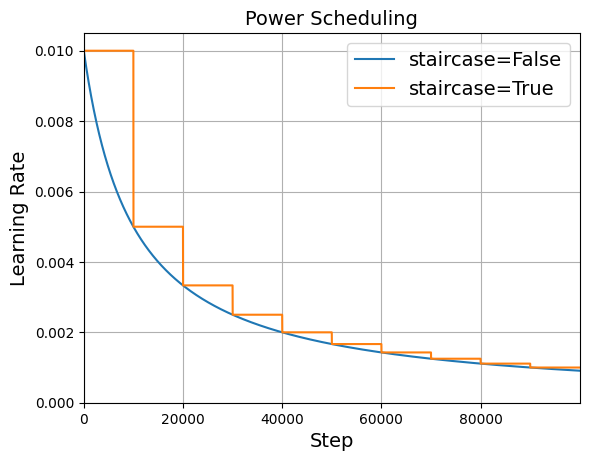

In [68]:
# extra code – this cell plots power scheduling with staircase=True or False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Exponential Scheduling

```python
learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)
```

In [69]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [70]:
history_exponential_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6935 - accuracy: 0.7615 - val_loss: 0.5004 - val_accuracy: 0.8240
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4784 - accuracy: 0.8311 - val_loss: 0.4574 - val_accuracy: 0.8368
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4330 - accuracy: 0.8467 - val_loss: 0.4198 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4102 - accuracy: 0.8543 - val_loss: 0.3998 - val_accuracy: 0.8592
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3932 - accuracy: 0.8607 - val_loss: 0.3956 - val_accuracy: 0.8564
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3808 - accuracy: 0.8649 - val_loss: 0.3935 - val_accuracy: 0.8588
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3724 - accuracy: 0.8666 - val_loss: 0.3824 - val_accuracy:

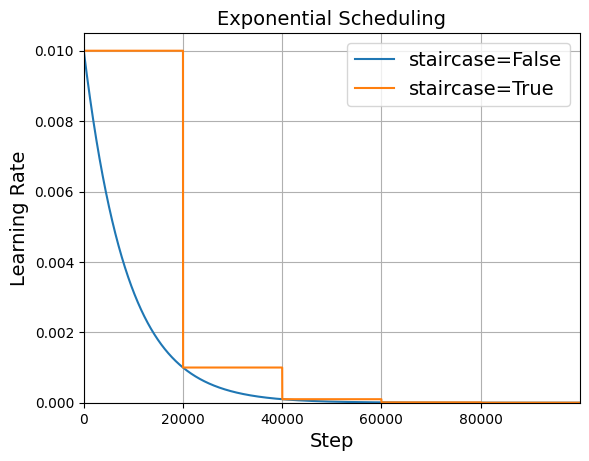

In [71]:
# extra code – this cell plots exponential scheduling

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras also provides a `LearningRateScheduler` callback class that lets you define your own scheduling function. Let's see how you could use it to implement exponential decay. Note that in this case the learning rate only changes at each epoch, not at each step:

In [72]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [73]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [74]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [75]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20


1719/1719 [==============================] - 2s 1ms/step - loss: 0.6966 - accuracy: 0.7576 - val_loss: 0.4847 - val_accuracy: 0.8264 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4739 - accuracy: 0.8342 - val_loss: 0.4534 - val_accuracy: 0.8346 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4287 - accuracy: 0.8471 - val_loss: 0.4218 - val_accuracy: 0.8510 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4057 - accuracy: 0.8563 - val_loss: 0.4012 - val_accuracy: 0.8572 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3860 - accuracy: 0.8627 - val_loss: 0.3915 - val_accuracy: 0.8588 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3716 - accuracy: 0.8679 - val_loss: 0.4060 - val_accuracy: 0.8558 - lr: 0.0056
Epoch 7/20
1719/1719 [==============================] - 2s 1ms/step -

Alternatively, the schedule function can take the current learning rate as a second argument:

In [76]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to use a custom scheduling function that updates the learning rate at each iteration rather than at each epoch, you can write your own callback class like this:

In [77]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [78]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [79]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/20


1719/1719 [==============================] - 3s 2ms/step - loss: 0.6736 - accuracy: 0.7701 - val_loss: 0.4832 - val_accuracy: 0.8284 - lr: 0.0089
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4725 - accuracy: 0.8325 - val_loss: 0.4496 - val_accuracy: 0.8332 - lr: 0.0079
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4280 - accuracy: 0.8477 - val_loss: 0.4160 - val_accuracy: 0.8550 - lr: 0.0071
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4037 - accuracy: 0.8579 - val_loss: 0.3927 - val_accuracy: 0.8614 - lr: 0.0063
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3841 - accuracy: 0.8643 - val_loss: 0.3850 - val_accuracy: 0.8628 - lr: 0.0056
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3695 - accuracy: 0.8694 - val_loss: 0.3909 - val_accuracy: 0.8642 - lr: 0.0050
Epoch 7/20
1719/1719 [==============================] - 2s 1ms/step -

### Piecewise Constant Scheduling

In [80]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [81]:
history_piecewise_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6990 - accuracy: 0.7574 - val_loss: 0.4839 - val_accuracy: 0.8270
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4709 - accuracy: 0.8349 - val_loss: 0.4717 - val_accuracy: 0.8330
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4232 - accuracy: 0.8491 - val_loss: 0.4197 - val_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3965 - accuracy: 0.8590 - val_loss: 0.3892 - val_accuracy: 0.8606
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3752 - accuracy: 0.8663 - val_loss: 0.3754 - val_accuracy: 0.8664
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3597 - accuracy: 0.8707 - val_loss: 0.3867 - val_accuracy: 0.8610
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3486 - accuracy: 0.8746 - val_loss: 0.3591 - val_accuracy:

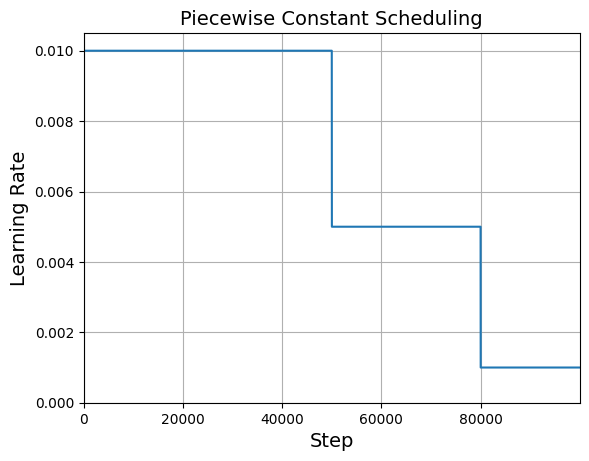

In [82]:
# extra code – this cell plots piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually:

In [83]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [84]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [85]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25


1719/1719 [==============================] - 3s 1ms/step - loss: 0.5420 - accuracy: 0.8048 - val_loss: 0.4740 - val_accuracy: 0.8194 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4494 - accuracy: 0.8409 - val_loss: 0.4614 - val_accuracy: 0.8220 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4316 - accuracy: 0.8471 - val_loss: 0.4426 - val_accuracy: 0.8460 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4247 - accuracy: 0.8511 - val_loss: 0.4397 - val_accuracy: 0.8494 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4109 - accuracy: 0.8564 - val_loss: 0.4410 - val_accuracy: 0.8468 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3563 - accuracy: 0.8713 - val_loss: 0.3936 - val_accuracy: 0.8608 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step -

We've looked at `InverseTimeDecay`, `ExponentialDecay`, and `PiecewiseConstantDecay`. A few more schedulers are available in `tf.keras.optimizers.schedules`, here is the full list:

In [86]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A LearningRateSchedule that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay – A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay – A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay – A LearningRateSchedule that uses a polynomial decay schedule.


### Performance Scheduling

In [87]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [88]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25


1719/1719 [==============================] - 2s 1ms/step - loss: 0.6828 - accuracy: 0.7688 - val_loss: 0.5021 - val_accuracy: 0.8198 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4689 - accuracy: 0.8357 - val_loss: 0.4463 - val_accuracy: 0.8382 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4210 - accuracy: 0.8503 - val_loss: 0.4078 - val_accuracy: 0.8548 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3949 - accuracy: 0.8597 - val_loss: 0.3815 - val_accuracy: 0.8610 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3740 - accuracy: 0.8664 - val_loss: 0.3727 - val_accuracy: 0.8654 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3574 - accuracy: 0.8721 - val_loss: 0.3783 - val_accuracy: 0.8656 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step -

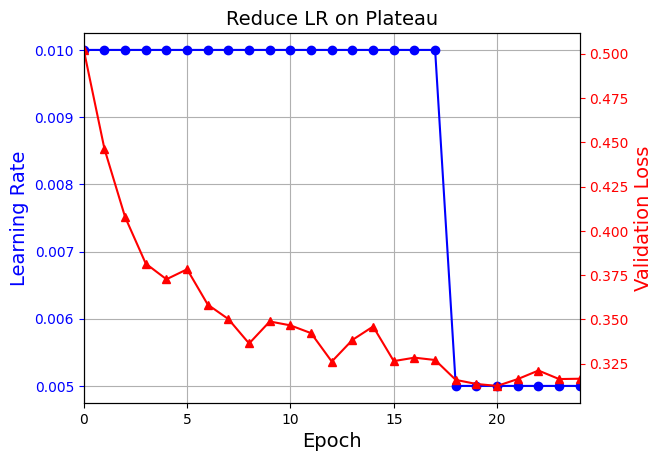

In [89]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [90]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [91]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [92]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [93]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 1s 2ms/step - loss: 1.8173 - accuracy: 0.3904


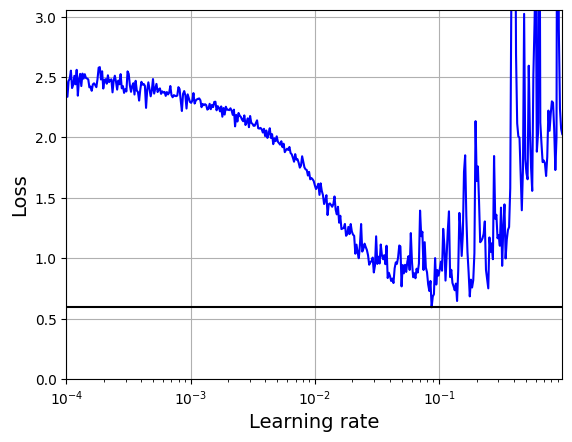

In [94]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [95]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [96]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.9663 - accuracy: 0.6895 - val_loss: 0.6014 - val_accuracy: 0.7932
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.5709 - accuracy: 0.8008 - val_loss: 0.4942 - val_accuracy: 0.8260
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4983 - accuracy: 0.8238 - val_loss: 0.4639 - val_accuracy: 0.8364
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4520 - accuracy: 0.8387 - val_loss: 0.4259 - val_accuracy: 0.8472
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4255 - accuracy: 0.8465 - val_loss: 0.4241 - val_accuracy: 0.8442
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3995 - accuracy: 0.8560 - val_loss: 0.5986 - val_accuracy: 0.7886
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3876 - accuracy: 0.8593 - val_loss: 0.3933 - val_accuracy: 0.8616
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [97]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [98]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [99]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [100]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2


1719/1719 [==============================] - 2s 1ms/step - loss: 3.1191 - accuracy: 0.7717 - val_loss: 1.8579 - val_accuracy: 0.8222
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 1.4263 - accuracy: 0.8119 - val_loss: 1.1302 - val_accuracy: 0.8156


## Dropout

In [101]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [102]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [103]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10


1719/1719 [==============================] - 3s 2ms/step - loss: 0.6794 - accuracy: 0.7498 - val_loss: 0.4494 - val_accuracy: 0.8344
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5167 - accuracy: 0.8105 - val_loss: 0.4163 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4741 - accuracy: 0.8276 - val_loss: 0.3898 - val_accuracy: 0.8548
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4496 - accuracy: 0.8345 - val_loss: 0.3848 - val_accuracy: 0.8560
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4339 - accuracy: 0.8401 - val_loss: 0.3746 - val_accuracy: 0.8626
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4282 - accuracy: 0.8408 - val_loss: 0.3699 - val_accuracy: 0.8620
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4169 - accuracy: 0.8461 - val_loss: 0.3711 - val_accuracy: 0.8620
Epo

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [104]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 1s 828us/step - loss: 0.3202 - accuracy: 0.8796


[0.3201764225959778, 0.8796363472938538]

In [105]:
model.evaluate(X_test, y_test)

  1/313 [..............................] - ETA: 4s - loss: 0.3787 - accuracy: 0.8438

313/313 [==============================] - 0s 795us/step - loss: 0.3775 - accuracy: 0.8647


[0.3774823248386383, 0.8647000193595886]

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## MC Dropout

In [106]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [107]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [108]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 75ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.011, 0.   , 0.299, 0.   ,
        0.69 ]], dtype=float32)

In [109]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.045, 0.   , 0.336, 0.001,
       0.618], dtype=float32)

In [110]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.086, 0.   , 0.219, 0.005,
       0.223], dtype=float32)

In [111]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8671

In [112]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [113]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [114]:
mc_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_89 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_90 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_91 (Dense)            (None, 10)              

Now we can use the model with MC Dropout:

In [115]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.32, 0.  , 0.62]],
      dtype=float32)

## Max norm

In [116]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [117]:
# extra code – shows how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5554 - accuracy: 0.8005 - val_loss: 0.4291 - val_accuracy: 0.8390
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4128 - accuracy: 0.8493 - val_loss: 0.4117 - val_accuracy: 0.8492
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3769 - accuracy: 0.8613 - val_loss: 0.3765 - val_accuracy: 0.8616
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3602 - accuracy: 0.8677 - val_loss: 0.3518 - val_accuracy: 0.8678
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3461 - accuracy: 0.8712 - val_loss: 0.3611 - val_accuracy: 0.8608
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3383 - accuracy: 0.8740 - val_loss: 0.3976 - val_accuracy: 0.8652
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3295 - accuracy: 0.8756 - val_loss: 0.3993 - val_accuracy:

# Exercises

## 1. to 7.

1. Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.
2. No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.
3. It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17). The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.
5. If you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.
6. One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply ℓ<sub>1</sub> regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.
7. Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.*

In [118]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [119]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [120]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [121]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170498071/170498071 [==============================] - 55s 0us/step


Now we can create the callbacks we need and train the model:

In [122]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [123]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs

In [124]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1401/1407 [============================>.] - ETA: 0s - loss: 3.0411 - accuracy: 0.1777INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 17s 8ms/step - loss: 3.0372 - accuracy: 0.1780 - val_loss: 2.0616 - val_accuracy: 0.2474
Epoch 2/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.9958 - accuracy: 0.2645INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 11s 8ms/step - loss: 1.9959 - accuracy: 0.2645 - val_loss: 1.9421 - val_accuracy: 0.2866
Epoch 3/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.8978 - accuracy: 0.3056INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 8ms/step - loss: 1.8978 - accuracy: 0.3056 - val_loss: 1.8818 - val_accuracy: 0.3078
Epoch 4/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.8244 - accuracy: 0.3374INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 11s 8ms/step - loss: 1.8245 - accuracy: 0.3374 - val_loss: 1.8470 - val_accuracy: 0.3346
Epoch 5/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.7639 - accuracy: 0.3605INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 8ms/step - loss: 1.7639 - accuracy: 0.3604 - val_loss: 1.7759 - val_accuracy: 0.3600
Epoch 6/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.7113 - accuracy: 0.3802INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 11s 8ms/step - loss: 1.7112 - accuracy: 0.3803 - val_loss: 1.7084 - val_accuracy: 0.3774
Epoch 7/100
1401/1407 [============================>.] - ETA: 0s - loss: 1.6688 - accuracy: 0.3985INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 11s 8ms/step - loss: 1.6689 - accuracy: 0.3985 - val_loss: 1.6811 - val_accuracy: 0.3820
Epoch 8/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.6364 - accuracy: 0.4141INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 9ms/step - loss: 1.6364 - accuracy: 0.4141 - val_loss: 1.6541 - val_accuracy: 0.4122
Epoch 9/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6077 - accuracy: 0.4226 - val_loss: 1.6613 - val_accuracy: 0.3960
Epoch 10/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5848 - accuracy: 0.4306 - val_loss: 1.6730 - val_accuracy: 0.3964
Epoch 11/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5657 - accuracy: 0.4370 - val_loss: 1.6586 - val_accuracy: 0.3944
Epoch 12/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.5453 - accuracy: 0.4474INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 8ms/step - loss: 1.5451 - accuracy: 0.4475 - val_loss: 1.6525 - val_accuracy: 0.3996
Epoch 13/100
1400/1407 [============================>.] - ETA: 0s - loss: 1.5250 - accuracy: 0.4527INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 8ms/step - loss: 1.5252 - accuracy: 0.4524 - val_loss: 1.6445 - val_accuracy: 0.4064
Epoch 14/100
1400/1407 [============================>.] - ETA: 0s - loss: 1.5151 - accuracy: 0.4558INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 9ms/step - loss: 1.5145 - accuracy: 0.4560 - val_loss: 1.6041 - val_accuracy: 0.4184
Epoch 15/100
1402/1407 [============================>.] - ETA: 0s - loss: 1.5002 - accuracy: 0.4633INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 8ms/step - loss: 1.4998 - accuracy: 0.4634 - val_loss: 1.5743 - val_accuracy: 0.4300
Epoch 16/100
1401/1407 [============================>.] - ETA: 0s - loss: 1.4822 - accuracy: 0.4695INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 8ms/step - loss: 1.4819 - accuracy: 0.4697 - val_loss: 1.5641 - val_accuracy: 0.4350
Epoch 17/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.4658 - accuracy: 0.4761INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 9ms/step - loss: 1.4657 - accuracy: 0.4762 - val_loss: 1.5610 - val_accuracy: 0.4458
Epoch 18/100
1399/1407 [============================>.] - ETA: 0s - loss: 1.4556 - accuracy: 0.4796INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 8ms/step - loss: 1.4554 - accuracy: 0.4798 - val_loss: 1.5510 - val_accuracy: 0.4450
Epoch 19/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4463 - accuracy: 0.4835 - val_loss: 1.5617 - val_accuracy: 0.4368
Epoch 20/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4325 - accuracy: 0.4883 - val_loss: 1.5674 - val_accuracy: 0.4340
Epoch 21/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.4216 - accuracy: 0.4894INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 11s 8ms/step - loss: 1.4215 - accuracy: 0.4894 - val_loss: 1.5256 - val_accuracy: 0.4512
Epoch 22/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4073 - accuracy: 0.4976 - val_loss: 1.5360 - val_accuracy: 0.4538
Epoch 23/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.3940 - accuracy: 0.5009 - val_loss: 1.5466 - val_accuracy: 0.4420
Epoch 24/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3890 - accuracy: 0.5044 - val_loss: 1.5564 - val_accuracy: 0.4412
Epoch 25/100
1398/1407 [============================>.] - ETA: 0s - loss: 1.3771 - accuracy: 0.5074INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 8ms/step - loss: 1.3769 - accuracy: 0.5075 - val_loss: 1.5199 - val_accuracy: 0.4612
Epoch 26/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.3633 - accuracy: 0.5139 - val_loss: 1.5571 - val_accuracy: 0.4574
Epoch 27/100
1398/1407 [============================>.] - ETA: 0s - loss: 1.3572 - accuracy: 0.5152INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 11s 8ms/step - loss: 1.3570 - accuracy: 0.5153 - val_loss: 1.5140 - val_accuracy: 0.4672
Epoch 28/100
1403/1407 [============================>.] - ETA: 0s - loss: 1.3470 - accuracy: 0.5193INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 11s 8ms/step - loss: 1.3475 - accuracy: 0.5192 - val_loss: 1.5111 - val_accuracy: 0.4658
Epoch 29/100
1398/1407 [============================>.] - ETA: 0s - loss: 1.3382 - accuracy: 0.5234INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 12s 8ms/step - loss: 1.3382 - accuracy: 0.5233 - val_loss: 1.4985 - val_accuracy: 0.4700
Epoch 30/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3297 - accuracy: 0.5241 - val_loss: 1.6281 - val_accuracy: 0.4440
Epoch 31/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3223 - accuracy: 0.5250 - val_loss: 1.5715 - val_accuracy: 0.4504
Epoch 32/100
1401/1407 [============================>.] - ETA: 0s - loss: 1.3102 - accuracy: 0.5301INFO:tensorflow:Assets written to: my_cifar10_model\assets


INFO:tensorflow:Assets written to: my_cifar10_model\assets


1407/1407 [==============================] - 11s 8ms/step - loss: 1.3101 - accuracy: 0.5301 - val_loss: 1.4932 - val_accuracy: 0.4692
Epoch 33/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3022 - accuracy: 0.5344 - val_loss: 1.5206 - val_accuracy: 0.4666
Epoch 34/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2936 - accuracy: 0.5381 - val_loss: 1.5253 - val_accuracy: 0.4642
Epoch 35/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2870 - accuracy: 0.5406 - val_loss: 1.5275 - val_accuracy: 0.4704
Epoch 36/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2785 - accuracy: 0.5435 - val_loss: 1.5535 - val_accuracy: 0.4622
Epoch 37/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.2700 - accuracy: 0.5457 - val_loss: 1.5307 - val_accuracy: 0.4676
Epoch 38/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2611 - accuracy: 0.5501 - val_loss: 1.5366 - val_accurac

In [125]:
model.evaluate(X_valid, y_valid)

 37/157 [======>.......................] - ETA: 0s - loss: 1.4650 - accuracy: 0.4721

157/157 [==============================] - 0s 1ms/step - loss: 1.4932 - accuracy: 0.4692


[1.4931517839431763, 0.4691999852657318]

The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to `my_cifar10_bn_model`.

In [126]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

Epoch 1/100
1404/1407 [============================>.] - ETA: 0s - loss: 2.0608 - accuracy: 0.2447INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


1407/1407 [==============================] - 32s 15ms/step - loss: 2.0604 - accuracy: 0.2448 - val_loss: 1.9180 - val_accuracy: 0.3204
Epoch 2/100
1407/1407 [==============================] - ETA: 0s - loss: 1.7812 - accuracy: 0.3604INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


1407/1407 [==============================] - 21s 15ms/step - loss: 1.7812 - accuracy: 0.3604 - val_loss: 1.7676 - val_accuracy: 0.3576
Epoch 3/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.6859 - accuracy: 0.3979INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


1407/1407 [==============================] - 20s 15ms/step - loss: 1.6857 - accuracy: 0.3979 - val_loss: 1.6280 - val_accuracy: 0.4200
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6219 - accuracy: 0.4208 - val_loss: 1.7568 - val_accuracy: 0.3766
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5662 - accuracy: 0.4444 - val_loss: 1.7137 - val_accuracy: 0.3978
Epoch 6/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.5205 - accuracy: 0.4605INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


1407/1407 [==============================] - 19s 14ms/step - loss: 1.5205 - accuracy: 0.4606 - val_loss: 1.5838 - val_accuracy: 0.4484
Epoch 7/100
1407/1407 [==============================] - 13s 10ms/step - loss: 1.4713 - accuracy: 0.4770 - val_loss: 1.6992 - val_accuracy: 0.4034
Epoch 8/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4348 - accuracy: 0.4873 - val_loss: 1.5942 - val_accuracy: 0.4374
Epoch 9/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4006 - accuracy: 0.5044 - val_loss: 1.6002 - val_accuracy: 0.4402
Epoch 10/100
1407/1407 [==============================] - ETA: 0s - loss: 1.3724 - accuracy: 0.5140INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


1407/1407 [==============================] - 21s 15ms/step - loss: 1.3724 - accuracy: 0.5140 - val_loss: 1.4886 - val_accuracy: 0.4706
Epoch 11/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3427 - accuracy: 0.5231 - val_loss: 1.5084 - val_accuracy: 0.4756
Epoch 12/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3136 - accuracy: 0.5351 - val_loss: 1.7358 - val_accuracy: 0.3970
Epoch 13/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.2875 - accuracy: 0.5456 - val_loss: 1.5830 - val_accuracy: 0.4570
Epoch 14/100
1407/1407 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.5514INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


INFO:tensorflow:Assets written to: my_cifar10_bn_model\assets


1407/1407 [==============================] - 20s 14ms/step - loss: 1.2601 - accuracy: 0.5514 - val_loss: 1.4244 - val_accuracy: 0.5050
Epoch 15/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.2398 - accuracy: 0.5646 - val_loss: 1.7113 - val_accuracy: 0.4478
Epoch 16/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.2243 - accuracy: 0.5690 - val_loss: 1.5360 - val_accuracy: 0.4716
Epoch 17/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.2006 - accuracy: 0.5738 - val_loss: 1.4473 - val_accuracy: 0.5160
Epoch 18/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1791 - accuracy: 0.5860 - val_loss: 1.6524 - val_accuracy: 0.4536
Epoch 19/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1621 - accuracy: 0.5900 - val_loss: 1.5283 - val_accuracy: 0.4908
Epoch 20/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1471 - accuracy: 0.5931 - val_loss: 1.5018 

[1.424391508102417, 0.5049999952316284]

* *Is the model converging faster than before?* Much faster! The previous model took 29 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 12 epochs and continued to make progress until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 50.7% validation accuracy instead of 46.7%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [127]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.9155 - accuracy: 0.3116INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 14s 7ms/step - loss: 1.9155 - accuracy: 0.3116 - val_loss: 1.7897 - val_accuracy: 0.3658
Epoch 2/100
1407/1407 [==============================] - ETA: 0s - loss: 1.7002 - accuracy: 0.3965INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 9s 7ms/step - loss: 1.7002 - accuracy: 0.3965 - val_loss: 1.6687 - val_accuracy: 0.4040
Epoch 3/100
1407/1407 [==============================] - ETA: 0s - loss: 1.6092 - accuracy: 0.4322INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 9s 7ms/step - loss: 1.6092 - accuracy: 0.4322 - val_loss: 1.6267 - val_accuracy: 0.4398
Epoch 4/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.5432 - accuracy: 0.4565 - val_loss: 1.6414 - val_accuracy: 0.4400
Epoch 5/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.4885 - accuracy: 0.4780INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 9s 7ms/step - loss: 1.4886 - accuracy: 0.4779 - val_loss: 1.5487 - val_accuracy: 0.4724
Epoch 6/100
1407/1407 [==============================] - ETA: 0s - loss: 1.4395 - accuracy: 0.4956INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 10s 7ms/step - loss: 1.4395 - accuracy: 0.4956 - val_loss: 1.5287 - val_accuracy: 0.4678
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4012 - accuracy: 0.5115 - val_loss: 1.5338 - val_accuracy: 0.4668
Epoch 8/100
1399/1407 [============================>.] - ETA: 0s - loss: 1.3543 - accuracy: 0.5259INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 9s 7ms/step - loss: 1.3545 - accuracy: 0.5260 - val_loss: 1.5034 - val_accuracy: 0.4794
Epoch 9/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.3237 - accuracy: 0.5390 - val_loss: 1.5184 - val_accuracy: 0.4690
Epoch 10/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2920 - accuracy: 0.5495 - val_loss: 1.5166 - val_accuracy: 0.4758
Epoch 11/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2609 - accuracy: 0.5611 - val_loss: 1.5093 - val_accuracy: 0.4868
Epoch 12/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.2322 - accuracy: 0.5708INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


INFO:tensorflow:Assets written to: my_cifar10_selu_model\assets


1407/1407 [==============================] - 9s 7ms/step - loss: 1.2321 - accuracy: 0.5708 - val_loss: 1.4738 - val_accuracy: 0.4938
Epoch 13/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.2073 - accuracy: 0.5777 - val_loss: 1.5033 - val_accuracy: 0.5012
Epoch 14/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.1859 - accuracy: 0.5877 - val_loss: 1.5135 - val_accuracy: 0.5046
Epoch 15/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.1550 - accuracy: 0.6020 - val_loss: 1.4851 - val_accuracy: 0.4970
Epoch 16/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.1305 - accuracy: 0.6091 - val_loss: 1.5391 - val_accuracy: 0.4992
Epoch 17/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.1039 - accuracy: 0.6180 - val_loss: 1.4827 - val_accuracy: 0.5036
Epoch 18/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0829 - accuracy: 0.6273 - val_loss: 1.5026 - val_accuracy

[1.473768711090088, 0.49380001425743103]

This model reached the first model's validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 50.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it's the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [128]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.9079 - accuracy: 0.3226INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 14s 7ms/step - loss: 1.9078 - accuracy: 0.3227 - val_loss: 1.7312 - val_accuracy: 0.3896
Epoch 2/100
1400/1407 [============================>.] - ETA: 0s - loss: 1.6753 - accuracy: 0.4106INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 10s 7ms/step - loss: 1.6750 - accuracy: 0.4106 - val_loss: 1.6619 - val_accuracy: 0.4224
Epoch 3/100
1403/1407 [============================>.] - ETA: 0s - loss: 1.5807 - accuracy: 0.4473INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 10s 7ms/step - loss: 1.5807 - accuracy: 0.4473 - val_loss: 1.6207 - val_accuracy: 0.4208
Epoch 4/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.5130 - accuracy: 0.4701INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 10s 7ms/step - loss: 1.5131 - accuracy: 0.4701 - val_loss: 1.5626 - val_accuracy: 0.4574
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4636 - accuracy: 0.4922 - val_loss: 1.5649 - val_accuracy: 0.4606
Epoch 6/100
1407/1407 [==============================] - ETA: 0s - loss: 1.4150 - accuracy: 0.5071INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


INFO:tensorflow:Assets written to: my_cifar10_alpha_dropout_model\assets


1407/1407 [==============================] - 10s 7ms/step - loss: 1.4150 - accuracy: 0.5071 - val_loss: 1.5131 - val_accuracy: 0.4828
Epoch 7/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.3633 - accuracy: 0.5288 - val_loss: 1.5442 - val_accuracy: 0.4854
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3265 - accuracy: 0.5385 - val_loss: 1.5163 - val_accuracy: 0.4884
Epoch 9/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2943 - accuracy: 0.5506 - val_loss: 1.5436 - val_accuracy: 0.4878
Epoch 10/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2628 - accuracy: 0.5650 - val_loss: 1.5481 - val_accuracy: 0.5070
Epoch 11/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2273 - accuracy: 0.5758 - val_loss: 1.5747 - val_accuracy: 0.4938
Epoch 12/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.1985 - accuracy: 0.5874 - val_loss: 1.5180 - val_accuracy: 

[1.513074517250061, 0.4828000068664551]

The model reaches 48.1% accuracy on the validation set. That's worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [129]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [130]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, tf.keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [131]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [132]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

  1/157 [..............................] - ETA: 19s

157/157 [==============================] - 0s 1ms/step


0.4842

We get back to roughly the accuracy of the model without dropout in this case (about 50.3% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [133]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 3s 6ms/step - loss: nan - accuracy: 0.1720


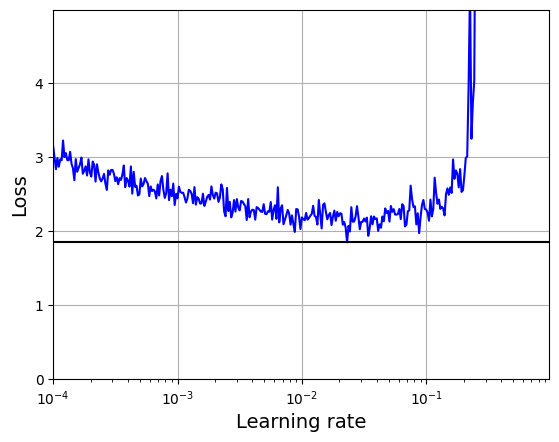

In [134]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [135]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [136]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 7ms/step - loss: 2.0477 - accuracy: 0.2860 - val_loss: 1.7866 - val_accuracy: 0.3764
Epoch 2/15
352/352 [==============================] - 2s 7ms/step - loss: 1.7552 - accuracy: 0.3787 - val_loss: 1.6500 - val_accuracy: 0.4200
Epoch 3/15
352/352 [==============================] - 2s 7ms/step - loss: 1.6185 - accuracy: 0.4266 - val_loss: 1.6398 - val_accuracy: 0.4284
Epoch 4/15
352/352 [==============================] - 2s 7ms/step - loss: 1.5462 - accuracy: 0.4511 - val_loss: 1.5922 - val_accuracy: 0.4482
Epoch 5/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4990 - accuracy: 0.4685 - val_loss: 1.6113 - val_accuracy: 0.4406
Epoch 6/15
352/352 [==============================] - 2s 7ms/step - loss: 1.4614 - accuracy: 0.4822 - val_loss: 1.5511 - val_accuracy: 0.4610
Epoch 7/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4261 - accuracy: 0.4940 - val_loss: 1.6464 - val_accuracy: 0.4396
Epoch 

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.7% to 52.0%).